In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.utils import check_random_state
import jax.numpy as jnp
import jaxopt
from tqdm import tqdm

### Create signals

In [28]:
# create original signal
def create_original_signal(sr=1000, T=2):
    ts = 1.0 / sr
    t = np.arange(0, T, ts)
    freq = 1.
    s = 3 * np.sin(2 * np.pi * freq * t)
    freq = 4
    s += np.sin(2 * np.pi * freq * t)
    freq = 7   
    s += 0.5 * np.sin(2 * np.pi * freq * t)
    return s

sr = 1000
T = 2
s = create_original_signal(sr=sr, T=T)

In [29]:
# create delayed versions of the original signal
def create_delayed_signal(s, a=1, b=0):
    t = np.arange(len(s))
    s_a = s
    if a != 1:
        f = interp1d(t, s)
        t_a = t * a
        if a > 1:
            t_a = t_a[t_a <= np.max(t)]
        s_a = f(t_a)
    s_ab = s_a
    if b != 0:
        fs = np.fft.fft(s_a)
        freqs = np.fft.fftfreq(fs.size)
        fs *= np.exp(-2 * np.pi * 1j * b * freqs)
        s_ab = np.real(np.fft.ifft(fs))
    return s_ab

a1 = 0.9
b1 = 0
s1 = create_delayed_signal(s, a=a1, b=b1)

a2 = 1.1
b2 = 0
s2 = create_delayed_signal(s, a=a2, b=b2)

a3 = 0.9
b3 = 21.5
s3 = create_delayed_signal(s, a=a3, b=b3)

Remark: we should compare signals only on a specific time-window to avoid boundary problems due to constant delays and because signals are shorter when a>1. 
If T = len(s), the window should be [tmin, tmax] with:
- tmin = b_max
- tmax = T / a_max - b_max

In [30]:
# delays constraints
b_max = 40
a_max = 1.2
t_min = b_max
t_max = len(s) / a_max - b_max

def assert_delays_constraints(a, b, a_max=1.2, b_max=40):
    assert 1 / a_max < a and a < a_max and -b_max < b and b < b_max

assert_delays_constraints(a=a1, b=b1, a_max=a_max, b_max=b_max)
assert_delays_constraints(a=a2, b=b2, a_max=a_max, b_max=b_max)
assert_delays_constraints(a=a3, b=b3, a_max=a_max, b_max=b_max)

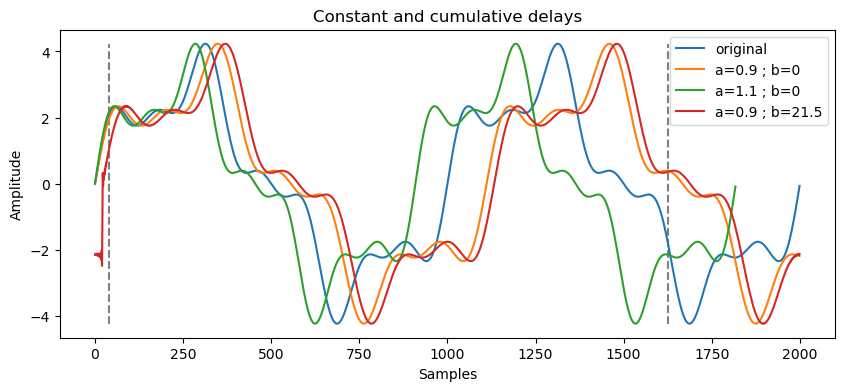

In [31]:
# plot
plt.subplots(figsize=(10, 4))
plt.plot(s, label='original')
plt.plot(s1, label=f'a={a1} ; b={b1}')
plt.plot(s2, label=f'a={a2} ; b={b2}')
plt.plot(s3, label=f'a={a3} ; b={b3}')
plt.vlines(x=t_min, ymin=np.min(s), ymax=np.max(s), linestyles='--', colors='grey')
plt.vlines(x=t_max, ymin=np.min(s), ymax=np.max(s), linestyles='--', colors='grey')
plt.legend()
plt.title("Constant and cumulative delays")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

### Reproduce signals from Fourier transform

In [41]:
# # compute Fourier transform of the original signal
# fs = np.fft.fft(s)
# N = len(fs)
# n = np.arange(N)
# freq = n / T

# # interpolation
# f = interp1d(freq, fs)

In [42]:
# # reproduce delayed signals from the Fourier transform of s
# def create_delayed_signal_fourier(f, freq, a=1, b=0):
#     # time dilation
#     N = len(freq)
#     N_a = N / a
#     freq_max = int(np.max(freq))
#     freq_a = np.linspace(0, freq_max, int(N_a))
#     fs_a = f(freq_a) / a
    
#     # time shift
#     freqs = np.fft.fftfreq(fs_a.size)
#     fs_ab = fs_a * np.exp(-2 * np.pi * 1j * b * freqs)
    
#     # inverse Fourier transform
#     s_ab = np.real(np.fft.ifft(fs_ab))
#     return s_ab

# s1_f = create_delayed_signal_fourier(f, freq, a=a1, b=b1)
# s2_f = create_delayed_signal_fourier(f, freq, a=a2, b=b2)
# s3_f = create_delayed_signal_fourier(f, freq, a=a3, b=b3)

In [43]:
# # plot
# plt.subplots(figsize=(10, 4))
# plt.plot(s, label='original')
# plt.plot(s1_f, label=f'a={a1} ; b={b1}')
# plt.plot(s2_f, label=f'a={a2} ; b={b2}')
# plt.plot(s3_f, label=f'a={a3} ; b={b3}')
# plt.vlines(x=t_min, ymin=np.min(s), ymax=np.max(s), linestyles='--', colors='grey')
# plt.vlines(x=t_max, ymin=np.min(s), ymax=np.max(s), linestyles='--', colors='grey')
# plt.legend()
# plt.title("Constant and cumulative delays")
# plt.xlabel("Samples")
# plt.ylabel("Amplitude")
# plt.show()

Remark: by using the Fourier transform, we obtain signals longer than s when a > 1.

### Possible explanation of the bad dilation

Interpolation of a Dirac function is really bad. Maybe the results would be better if we used a smoother frequency spectrum. I could for instance use the data generation functions in sources_generation.py.

In [44]:
# fs = np.fft.fft(s)
# N = len(fs)
# n = np.arange(N)
# freq = n / T
# f = interp1d(freq, fs)

# a = 1.1
# N_a = N * a
# freq_max = int(np.max(freq))
# freq_a = np.linspace(0, freq_max, int(N_a))
# fs_a = f(freq_a) / a

# plt.stem(freq, np.abs(fs), 'b', markerfmt=" ", basefmt="-b", label='fs')
# plt.stem(freq_a, np.abs(fs_a), 'r', markerfmt=" ", basefmt="-b", label='fs_a')
# plt.legend()
# plt.xlabel('Freq (Hz)')
# plt.ylabel('FFT Amplitude |fs(freq)|')
# plt.xlim(0, 10)
# plt.show()

### Estimate delay parameters with jax

In [45]:
# similar function as above but with jnp instead of np
# (thus we use jnp.interp and not scipy.interpolate.interp1d anymore)
# apply dilation in the Fourier domain
# def create_delayed_signal_fourier_jax(f, freq, a=1, b=0):
#     # time dilation
#     N = len(freq)
#     # N_a = int(N / a)
#     N_a = jnp.array(N / a, int)
#     # freq_max = int(jnp.max(freq))
#     freq_max = jnp.array(jnp.max(freq), int)
#     freq_a = jnp.linspace(0, freq_max, N_a)
#     fs_a = f(freq_a) / a
    
#     # time shift
#     freqs = jnp.fft.fftfreq(fs_a.size)
#     fs_ab = fs_a * jnp.exp(-2 * jnp.pi * 1j * b * freqs)
    
#     # inverse Fourier transform
#     s_ab = jnp.real(jnp.fft.ifft(fs_ab))
#     return s_ab

# similar function as above but with jnp instead of np 
# (thus we use jnp.interp and not scipy.interpolate.interp1d anymore).
# also, apply dilation in the time domain instead of the Fourier domain
def create_delayed_signal_jax(s, a=1, b=0):
    # time dilation
    t = jnp.arange(len(s))
    t_a = t * a
    s_a = jnp.interp(x=t_a, xp=t, fp=s, right=0)

    # time shift
    fs = jnp.fft.fft(s_a)
    freqs = jnp.fft.fftfreq(fs.size)
    fs *= jnp.exp(-2 * np.pi * 1j * b * freqs)
    s_ab = jnp.real(jnp.fft.ifft(fs))

    return s_ab

In [37]:
def estimate_const_cumul_delays(s_ind, s_avg, a_max=1.2, b_max=40, maxiter=100):
    # fs = jnp.fft.fft(s_avg)
    # N = len(fs)
    # n = jnp.arange(N)
    # freq = n / T
    # f = interp1d(freq, fs)
    
    t_min = int(b_max)
    t_max = int(len(s) / a_max - b_max)
    
    def loss_function(a_b):
        a, b = a_b[0], a_b[1]
        # s_avg_ab = create_delayed_signal_fourier_jax(f, freq, a=a, b=b)
        s_avg_ab = create_delayed_signal_jax(s=s_avg, a=a, b=b)
        loss = jnp.linalg.norm(s_ind[t_min: t_max] - s_avg_ab[t_min: t_max])
        return loss
    
    init_params = jnp.array([1., 0.])  # initialization is a=1 and b=0
    bounds_ab = (jnp.array([1/a_max, -b_max]), jnp.array([a_max, b_max]))
    solver = jaxopt.LBFGSB(fun=loss_function, maxiter=maxiter)
    ab, _ = solver.run(init_params, bounds=bounds_ab)
    a, b = ab[0], ab[1]
    
    return a, b

a_res, b_res = estimate_const_cumul_delays(s1, s)

In [46]:
s_res = create_delayed_signal_jax(s, a=a_res, b=b_res)
print(f"a : {a_res} \nb : {b_res}")

a : 0.9002091884613037 
b : 0.2582399249076843


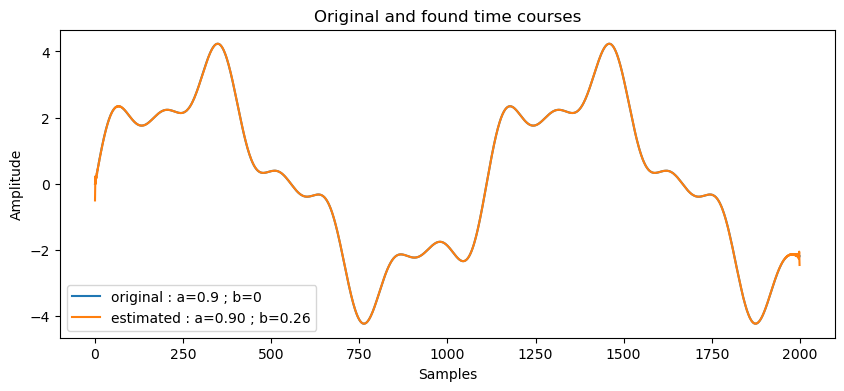

In [47]:
# plot
plt.subplots(figsize=(10, 4))
plt.plot(s1, label=f'original : a={a1} ; b={b1}')
plt.plot(s_res, label=f'estimated : a={a_res:.2f} ; b={b_res:.2f}')
plt.legend()
plt.title("Original and found time courses")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

Remark: estimating the dilation parameter in the time domain and in the Fourier domain is equivalent: it takes similar times and is differentiable in both cases. However, it is more precise in the time domain as we don't use Dirac-like frequencies. 

### Multiple seeds

In [63]:
# estimate delay parameters for multiple seeds
nb_seeds = 20
random_state = 0
rng = check_random_state(random_state)
a_rand = rng.uniform(1/a_max, a_max, size=nb_seeds)
b_rand = rng.uniform(-b_max, b_max, size=nb_seeds)
a_res = np.zeros(nb_seeds)
b_res = np.zeros(nb_seeds)

for i in tqdm(range(nb_seeds)):
    s_i = create_delayed_signal(s, a=a_rand[i], b=b_rand[i])
    a_res[i], b_res[i] = estimate_const_cumul_delays(s_i, s)

100%|██████████| 20/20 [03:57<00:00, 11.87s/it]


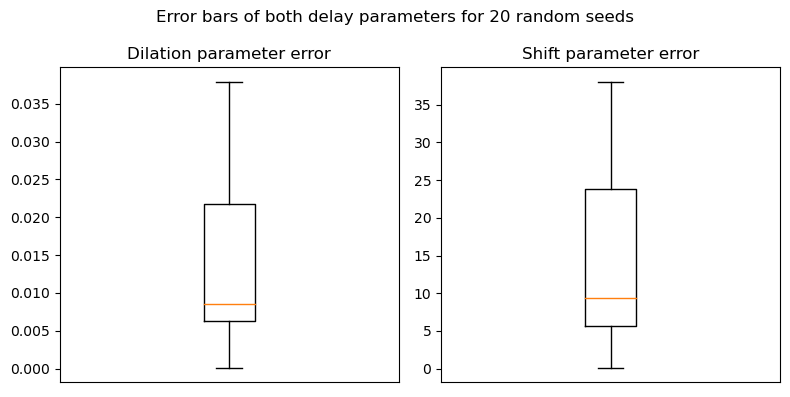

In [92]:
# box plot
a_error = np.abs(a_res - a_rand)
b_error = np.abs(b_res - b_rand)

plt.subplots(1, 2, figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.boxplot(a_error)
plt.title("Dilation parameter error")
plt.xticks([])

plt.subplot(1, 2, 2)
plt.boxplot(b_error)
plt.title("Shift parameter error")
plt.xticks([])

plt.suptitle(f"Error bars of both delay parameters for {nb_seeds} random seeds")
plt.tight_layout()
plt.show()

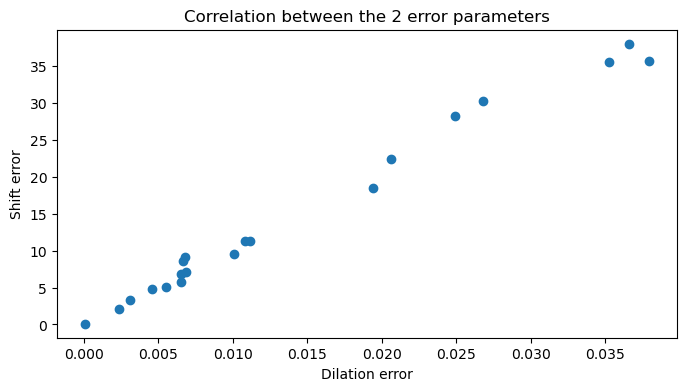

In [65]:
# check if the two errors are correlated
plt.figure(figsize=(8, 4))
plt.scatter(a_error, b_error)
plt.xlabel("Dilation error")
plt.ylabel("Shift error")
plt.title("Correlation between the 2 error parameters")
plt.show()

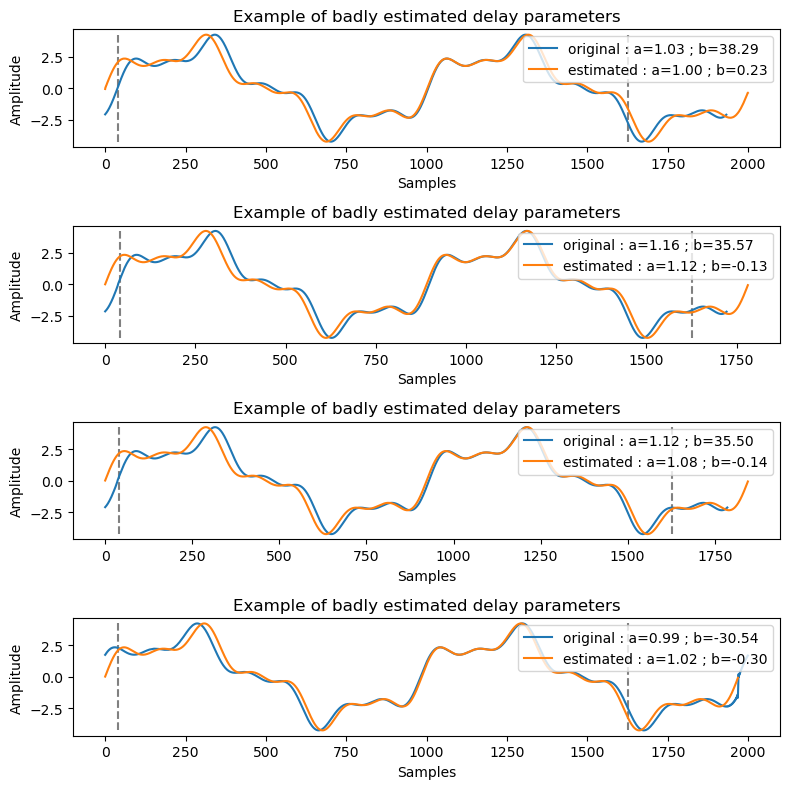

In [90]:
# plot function
def plot_2_signals(s1, s2, a1, a2, b1, b2):
    plt.plot(s1, label=f'original : a={a1:.2f} ; b={b1:.2f}')
    plt.plot(s2, label=f'estimated : a={a2:.2f} ; b={b2:.2f}')
    plt.vlines(x=t_min, ymin=np.min(s), ymax=np.max(s), linestyles='--', colors='grey')
    plt.vlines(x=t_max, ymin=np.min(s), ymax=np.max(s), linestyles='--', colors='grey')
    plt.legend()
    plt.title("Example of badly estimated delay parameters")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")

# visualize what happens when the error is high
nb_inds = 4
inds = np.argsort(b_error)[-nb_inds:][::-1]

plt.subplots(nb_inds, 1, figsize=(8, 2*nb_inds))
for i, ind in enumerate(inds):
    plt.subplot(nb_inds, 1, i+1)
    s_true = create_delayed_signal(s, a=a_rand[ind], b=b_rand[ind])
    s_estimated = create_delayed_signal(s, a=a_res[ind], b=b_res[ind])
    plot_2_signals(s_true, s_estimated, a_rand[ind], a_res[ind], b_rand[ind], b_res[ind])
plt.tight_layout()
plt.show()

Remarks:
- dilation error and shift error are strongly correlated
- when delay parameters are badly estimated, the pattern is always the same: dilation parameter is compensated by shift parameter, and vice versa. 